# Homework 3

### 1.

We consider the LASSO problem :

\begin{equation*}
\begin{split}
\min_w & \frac{1}{2}\vert\vert Xw - y \vert\vert^2_2 + \lambda \vert\vert w \vert\vert_1\\
\iff \min_{w, z} & \frac{1}{2} \vert\vert z \vert\vert^2_2 +  \lambda \vert\vert w \vert\vert_1\\
     \text{s.t.} & z = Xw - y
\end{split}
\end{equation*}

where we introduce the dummy variable $z$ to compute the dual of the problem in a useful form.

Indeed, using this form of the problem, the Lagrangian is, with $\nu$ denoting the Lagrange multiplier :

\begin{equation*}
\begin{split}
\mathscr{L} (w, z, \nu) &= \frac{1}{2} \vert\vert z \vert\vert^2_2 + \lambda \vert\vert w \vert\vert_1 + \nu^T\left( z - Xw + y \right)\\
&= \frac{1}{2} \vert\vert z \vert\vert^2_2 + \nu^T z + \lambda \left( \vert\vert w \vert\vert_1 - \frac{1}{\lambda} \left( X^T\nu \right)^T w \right) + \nu^T y\\
\end{split}
\end{equation*}

Minimizing $\mathscr{L}(z, w, \nu)$ over $w$ is equivalent to :

$$\max_w \lambda \left( \frac{1}{\lambda} \left( X^T\nu \right)^T w - \vert\vert w \vert\vert_1 \right)$$

where we recognize the conjugate norm $\lambda \vert\vert \frac{1}{\lambda} X^T \nu \vert\vert_1^*$, therefore :

\begin{equation*}
\begin{split}
\min_{w} \mathscr{L} (w, z, \nu) &= -\infty \text{ if } \vert\vert \frac{1}{\lambda} X^T \nu \vert\vert_{\infty} > 1\\
                             &= \frac{1}{2} \vert\vert z \vert\vert^2_2 + \nu^T z + \nu^T y \text{ otherwise}\\
                             &= z^T \left( \frac{1}{2}z + \nu \right) + \nu^T y
\end{split}
\end{equation*}

We compute the gradient of $\mathscr{L}$ with respect to $z$ to minimize it (i.e. compute the Lagrange dual function $g(\nu)$) :

\begin{equation*}
\begin{split}
\nabla \mathscr{L}(z) &= \frac{1}{2} z + \nu + \frac{1}{2}z\\
                      &= z + \nu\\
\implies \nabla \mathscr{L}(z) &= 0 \iff z = -\nu
\end{split}
\end{equation*}

Therefore, we obtain :

$$g(\nu) = -\frac{1}{2} \nu^T\nu + \nu^Ty$$

and the dual problem expressed as a quadratic program is :

\begin{equation*}
\begin{split}
\min_{v} \, -g(v) &= v^T Q v + p^T v\\
       \text{s.t. } Av &\leq b
\end{split}
\end{equation*}

where $v = \nu, Q = \frac{1}{2} I_n, p = -y,$
\begin{align}
A &= \begin{bmatrix}
X^T\\
-X^T
\end{bmatrix}
\end{align}
and $b = \lambda \mathbb{1}_{2d}$ (which is $\vert\vert \frac{1}{\lambda} X^T\nu \vert\vert_\infty \leq 1$ written in matrix form)

### 2.

Let us now implement the barrier method to solve this dual problem.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Union, Tuple
import sys
import cvxpy as cvx  # to check if we get the correct solutions

In [2]:
# Backtracking Line Search params
BLS_ALPHA = 0.1
BLS_BETA = 0.7

# Newton precision
NEWTON_EPSILON = 1e-8

LOGBARR_MU = 10.  # path update : t <- µ * t
LOGBARR_T0 = 1.  # first t value (start of path)

# Fix seed for reproducible tests
# np.random.seed(1)

In [3]:
def log_barrier(vals: np.ndarray) -> float:
    """
    Log barrier function. Expects NEGATIVE values as inputs.
    (This is the function "phi" from slide 7 of Lecture 5)

    :param vals: value of constraint functions
    :return: log barrier evaluation
    """
    if np.any(vals >= 0):
        raise ValueError('[log_barrier] Positive value encountered')

    return -np.sum(np.log(-vals))

In [4]:
def check_objective_def(A: np.ndarray,
                        b: np.ndarray,
):
    """
    Create a function that checks if the objective is defined

    :param A: the inequality constraint matrix
    :param b: the inequality constraint vector
    :return: A function of x that returns True if Ax - b < 0
    """
    def _check(x):
        u = A @ x
        u = u - b
        return np.all(u < 0)

    return _check

In [5]:
def bls(f: Callable,
        gradf_x: Union[np.ndarray, float],
        x: Union[np.ndarray, float],
        delta_x: Union[np.ndarray, float],
        alpha: float,
        beta: float,
        check_def: Callable,
        ) -> float:
    """
    Backtracking Line Search algorithm.
    The algorithm may not converge if we are very close to the optimum,
    therefore we break out of the loop if the step length becomes zero
    (the loop becomes infinite in this case)

    :param f: the objective function (real-valued)
    :param gradf_x: the gradient of f at x
    :param x: the current point from which to descent
    :param delta_x: the descent direction
    :param alpha: parameter in [0, 1/2]
    :param beta: shrinkage parameter in [0, 1)
    :param check_def: function that returns True on an input v if f(v) is defined
    :return: the optimal (if reached) step length t
    """
    t = 1.

    while (
            not check_def(x + t * delta_x)
            or f(x + t * delta_x) >= f(x) + alpha * t * np.dot(gradf_x, delta_x)
    ):
        t = beta * t
        if t < sys.float_info.epsilon:
            break

    return t

#### Computation of the gradient and the Hessian


The gradient and Hessian of $g_t(v) = t\left( v^TQv + p^Tv \right) - \sum\limits_{k=1}^{2d} \log \left( b - Av \right)_k$ are :

$$\nabla g_t(v) = t(2Qv + p) - \sum_{k=1}^{2d} \frac{1}{(Av - b)_k} A^T_k$$

where $A^T_k$ is the $k$-th column of $A^T$ i.e. the $k$-th line of $A$, and

$$\nabla^2 g_t(v) = t2Q + \sum_{k=1}^{2d} \frac{1}{(Av - b)_k^2} M(k)$$

where

$$M(k)_{ij} = A_{ki} A_{kj}$$

i.e. $M(k)$ is the "tensor product" of the $k$-th line of $A$ with itself :

\begin{align}
M(k) &= \begin{bmatrix}
A_{k1}\\
\vdots\\
A_{kn}\\
\end{bmatrix}
\begin{bmatrix}
A_{k1} \hdots A_{kn}
\end{bmatrix}
\end{align}

Using the element-wise multiplication rule of NumPy arrays, these weighted sums are written in short expressions in the code below.

In [6]:
def centering_step(
        Q: np.ndarray,
        p: np.ndarray,
        A: np.ndarray,
        b: np.ndarray,
        t: float,
        v0: np.ndarray,
        eps: float
) -> np.ndarray:
    """
    Perform the centering step of the log-barrier algorithm.
    Compute the steepest descent in local Hessian norm (Newton algorithm)
    and choose a step length using backtracking line search

    :param Q: Hessian of the original objective
    :param p: linear coefficients of the original objective
    :param A: Constraint matrix
    :param b: Constraint vector
    :param t: Current log-barrier parameter
    :param v0: Starting point
    :param eps: Desired precision
    :return: the history of points of the Newton descent
    """

    objective_f = lambda v: t * (v.T @ Q @ v + p @ v) + log_barrier(A @ v - b)
    def_checker = check_objective_def(A, b)
    v = v0
    v_history = [v]
    previous_decrement = None  # debug purposes (check decreasing decrement)

    while True:
        # Compute gradient and Hessian of the objective
        u = A @ v - b
        grad = t * (2 * Q @ v + p) - np.sum(1 / u * A.T, axis=1)  # sum( 1/(Av-b)[k]*(k-th line of A) )

        barrier_hess = (1 / u**2 * A.T) @ A
        hess = t * 2 * Q + barrier_hess

        delta_v = np.linalg.solve(hess, -grad)  # Newton descent direction
        newton_decrement_sq = np.dot(grad, -delta_v)

        # Sanity check
        if previous_decrement is None:
            previous_decrement = newton_decrement_sq
        if newton_decrement_sq - previous_decrement > 0.:
            print('[WARNING][centering_step] Newton decrement increasing')

        # Stop
        if 0.5 * newton_decrement_sq <= eps:
            return np.array(v_history, dtype=float)

        # Descend
        step_l = bls(
            f=objective_f,
            gradf_x=grad,
            x=v,
            delta_x=delta_v,
            alpha=BLS_ALPHA,
            beta=BLS_BETA,
            check_def=def_checker,
        )
        reached_zero = step_l < sys.float_info.epsilon
        if reached_zero:
            return np.array(v_history, dtype=float)

        v = v + step_l * delta_v
        v_history.append(v)


In [7]:
def barr_method(
        Q: np.ndarray,
        p: np.ndarray,
        A: np.ndarray,
        b: np.ndarray,
        v0: np.ndarray,
        eps: float,
        mu=LOGBARR_MU,
        t0=LOGBARR_T0
) -> np.ndarray:
    def_checker = check_objective_def(A, b)
    if not def_checker(v0):
        raise ValueError('The log barrier is not defined for the input v0')

    m = len(b)
    t = t0
    v_history = [v0]
    v = v0

    while True:
        v = centering_step(Q=Q,
                           p=p,
                           A=A,
                           b=b,
                           t=t,
                           v0=v,
                           eps=NEWTON_EPSILON)[-1]

        v_history.append(v)

        if m / t < eps:
            break

        t = mu * t

    return np.array(v_history, dtype=float)

### 3.

We now test the implemented LASSO solver using random data

In [8]:
def generate_random_data(n_samples, dim, scale, w_density, y_dev) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate random data with sparse linear relationship.

    :param n_samples: # of samples drawn
    :param dim: dimension of each sample
    :param scale: bounds samples' coordinates between [-scale, +scale]
    :param w_density: density of the relationship (ie density of w_star)
    :param y_dev: deviation of observations with the linear relationship
    :return: X : matrix of samples
             y : observations (labels)
             w_star : sparse vector encoding the linear relationship
    """
    X = scale * 2 * (np.random.rand(n_samples, dim) - 0.5)
    w_star = np.random.randn(dim)
    idx_nonzero = np.random.choice(range(dim), int((1 - w_density) * dim), replace=False)
    for i in idx_nonzero:
        w_star[i] = 0.
    y = X @ w_star + np.random.normal(0, y_dev, size=n_samples)

    return X, y

In [9]:
# A very small example
n = 3
d = 2
scale = 10.
X, y = generate_random_data(n, d, scale=scale, w_density=0.4, y_dev=0.5)
_lambda = 10.

Q = 0.5 * np.eye(n)
p = -y
A = np.vstack([X.T, -X.T])
b = np.full(shape=2 * d, fill_value=_lambda)

In [10]:
v0 = np.zeros(shape=n)  # v0 stricly feasible (for all lambda > 0)
v_hist = barr_method(Q=Q,
                     p=p,
                     A=A,
                     b=b,
                     v0=v0,
                     eps=1e-16)

In [11]:
def dual_objective(v):
    res = np.zeros(len(v), dtype=float)
    for i, _v in enumerate(v):
        res[i] = np.dot(_v, np.dot(Q, _v)) + np.dot(p, _v)
    return res

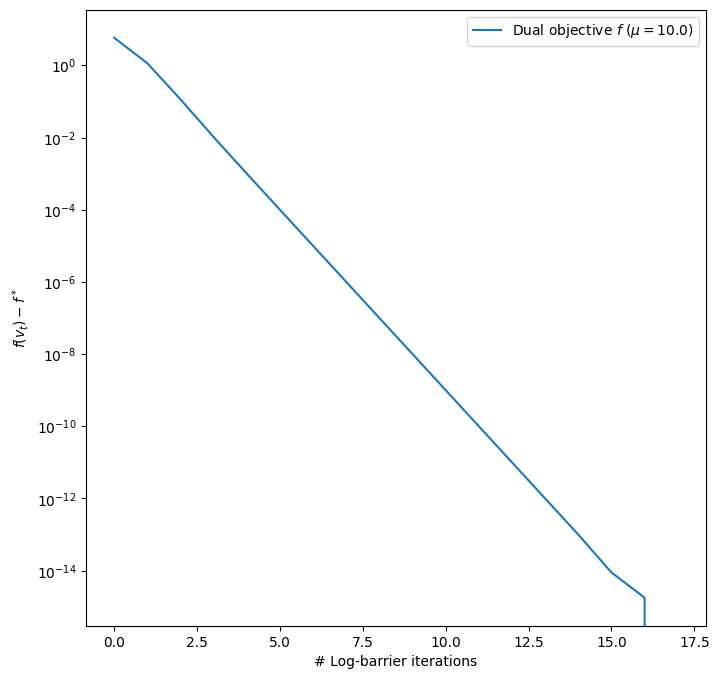

In [12]:
plt.figure(figsize=(8, 8))
plt.semilogy(dual_objective(v_hist[:-1]) - dual_objective([v_hist[-1]]), label=f'Dual objective $f$ ($\mu = {LOGBARR_MU})$')
plt.legend()
plt.ylabel('$f(v_t) - f^*$')
_ = plt.xlabel('# Log-barrier iterations')

In [13]:
# We propose to solve the dual with cvxpy to ensure we get the same result
# Create dual
v = cvx.Variable(shape=n, name='v')
_Q = cvx.Parameter(shape=Q.shape, name='Q', PSD=True)
_Q.value = Q
_p = cvx.Parameter(shape=p.shape, name='p')
_p.value = p
dual_constraints = [A @ v <= b]

dual_obj_cvx = cvx.Minimize(cvx.quad_form(x=v, P=_Q) + _p.T @ v)
dual_problem = cvx.Problem(dual_obj_cvx, dual_constraints)
dual_problem.solve()

print(f'CVXPy Status : {dual_problem.status}\n'
      f'Optimal value as found by CVXPy :              {dual_problem.value}\n'
      f'Optimal value as found by the barrier method : {dual_objective([v_hist[-1]])[0]}')

CVXPy Status : optimal
Optimal value as found by CVXPy :              -5.821014244449534
Optimal value as found by the barrier method : -5.821014244449534


/home/alderson/Mines/3A/MVA/Convex_Optimization/Homeworks/HW3/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


As expected, a linear convergence in semilog scale, and we see that we converged to the same value as CVXPy : this log-barrier implementation thus works as intended. Moreover, we see that the precision threshold of the log-barrier behaves correctly by looking at the decimals of the optima.

In [14]:
# A more complex example
n = 50
d = 300

scale = 1.
X, y = generate_random_data(n, d, scale, w_density=0.4, y_dev=0.5)
_lambda = 10.

Q = 0.5 * np.eye(n)
p = -y
A = np.vstack([X.T, -X.T])
b = np.full(shape=2 * d, fill_value=_lambda)

In [15]:
print(f'X^T X is singular : {np.linalg.cond(X.T @ X) >= 1 / sys.float_info.epsilon}')

X^T X is singular : True


In [16]:
v0 = np.zeros(shape=n)  # v0 stricly feasible (for all lambda > 0)
v_hist = barr_method(Q=Q,
                     p=p,
                     A=A,
                     b=b,
                     v0=v0,
                     eps=1e-16)

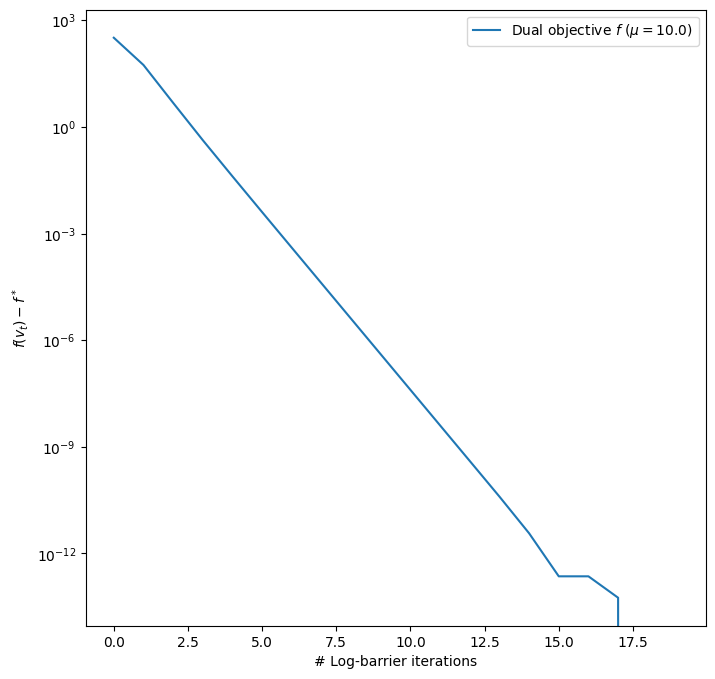

In [17]:
plt.figure(figsize=(8, 8))
plt.semilogy(dual_objective(v_hist[:-1]) - dual_objective([v_hist[-1]]), label=f'Dual objective $f$ ($\mu = {LOGBARR_MU})$')
plt.legend()
plt.ylabel('$f(v_t) - f^*$')
_ = plt.xlabel('# Log-barrier iterations')

In [18]:
# Create dual
v = cvx.Variable(shape=n, name='v')
_Q = cvx.Parameter(shape=Q.shape, name='Q', PSD=True)
_Q.value = Q
_p = cvx.Parameter(shape=p.shape, name='p')
_p.value = p
dual_constraints = [A @ v <= b]

dual_obj_cvx = cvx.Minimize(cvx.quad_form(x=v, P=_Q) + _p.T @ v)
dual_problem = cvx.Problem(dual_obj_cvx, dual_constraints)
dual_problem.solve()

# N.B. : the displayed values are optimal values for the LASSO dual,
# which are the opposite of (QP)'s optimal value.
print(f'CVXPy Status : {dual_problem.status}\n'
      f'Optimal value as found by CVXPy :              {-dual_problem.value}\n'
      f'Optimal value as found by the barrier method : {-dual_objective([v_hist[-1]])[0]}')

CVXPy Status : optimal
Optimal value as found by CVXPy :              323.4843180569052
Optimal value as found by the barrier method : 323.484318056905


Still a very quick convergence, both in number of iterations and in time !

We must now relate the optimum of the dual with the optimum of the primal. The primal

\begin{equation*}
\begin{split}
\min_{w, z} & \frac{1}{2} \vert\vert z \vert\vert^2_2 +  \lambda \vert\vert w \vert\vert_1\\
     \text{s.t. } & z = Xw - y
\end{split}
\end{equation*}
is convex (by convexity of norms in the objective function, and linearity of equality constraints), and Slater's condition is verified since the domain of the objective and the (non-existent) inequality constraint is $(w, z) \in \mathcal{D} = \mathbb{R}^d \times \mathbb{R}^n$, which is open. Therefore, any feasible point is in the interior of $\mathcal{D}$. Moreover, the computation of the Lagrange dual function established relationships between the primal and dual variables :

\begin{equation*}
\begin{split}
z^* &= -\nu^* \text{ by definition of the Lagrange dual function (from } \nabla \mathscr{L}(z, \nu ) = 0 \iff z = -\nu \text{ )}\\
X w^* &= z^* + y \text{ by constraints}\\
\iff w^* &= \left( X^T X \right)^{-1} X^T (z^* + y) \text{ if rank}(X) = d
\end{split}
\end{equation*}

In practice, if $n < d$, we always have $\text{rank}(X) < d$. However, solving the system to get a value of $w^*$ still results in a solution of the primal with the same residues. As highlighted by [Tibshirani (2012), The Lasso Problem and Uniqueness](https://arxiv.org/abs/1206.0313), it may be difficult to choose the "right" $w^*$ value as it is difficult to define such a notion, particularly when different candidates have different non-zero coefficients (supports). In the same paper, Tibshirani derives a sufficient condition for uniqueness from the KKT conditions (pages 4, 5) : considering the set

$$\varepsilon = \{ i \in \{1, ..., d\}, \vert X_i^T (X w^* - y) \vert = \lambda \}$$

where $X_i \in \mathbb{R}^n$ denotes a column of $X$, and the matrix $X_\varepsilon$ defined by the concatenation of the columns $X_j, j \in \varepsilon$, then the solution is unique if $\text{rank}(X_\varepsilon) = \text{Card} (\varepsilon)$, and, denoting $s$ the vector containing the signs of the elements of $X_\varepsilon^T (y - Xw^*)$ :

\begin{equation*}
\begin{split}
w^*_\varepsilon &= \left( X_\varepsilon^T X_\varepsilon \right)^{-1} \left( X^T_\varepsilon y - \lambda s \right)\\
w^*_{\bar{\varepsilon}} &= 0\\
\end{split}
\end{equation*}

where $w^*_\varepsilon$ denotes the vector of components of $w^*$ whose indices are in $\varepsilon$

We can try to apply this criterion to get the solution.

In [19]:
def compute_epsilon_set(X,
                        resid,
                        _lambda,
                        tol=1e-12
                        ):
    X_cols = X.T
    epsilon_set = []
    for i, col in enumerate(X_cols):
        if abs(abs((np.dot(col, resid))) - _lambda) < tol:
            epsilon_set.append(i)

    return epsilon_set

In [20]:
eps_set = compute_epsilon_set(X, -v_hist[-1], _lambda=_lambda)
print(f'Size of epsilon set : {len(eps_set)}')

Size of epsilon set : 40


In [21]:
def compute_w_epsilon(X,
                      resid,
                      y,
                      _lambda,
                      ):
    w_epsilon = np.zeros(shape=len(X[0]), dtype=float)
    eps_set = compute_epsilon_set(X, resid, _lambda)
    if not eps_set:
        print(f'[WARNING] epsilon set is empty. Returning an array of zeroes')
        return w_epsilon

    X_epsilon = X.T[eps_set].T
    s = np.sign(np.dot(X_epsilon.T, -resid)) # -resid is y - Xw

    w_epsilon_nonzero = np.dot(np.linalg.inv(X_epsilon.T @ X_epsilon), np.dot(X_epsilon.T, y) - _lambda * s)
    for i, loc in enumerate(eps_set):
        w_epsilon[loc] = w_epsilon_nonzero[i]

    return w_epsilon

In [22]:
w_eps = compute_w_epsilon(X, resid=-v_hist[-1], y=y, _lambda=_lambda)

In [23]:
def primal_objective(X, w, y, _lambda):
    return 0.5 * np.dot(X @ w - y, X @ w - y)  + _lambda * np.linalg.norm(w, ord=1)

In [24]:
# Compare with cvxpy
# Create primal
w = cvx.Variable(shape=d, name='w')
w.value = np.zeros(shape=d, dtype=float)

lambd = cvx.Parameter(nonneg=True, name='lambda')
lambd.value = _lambda

primal_obj_cvx = cvx.Minimize(
    cvx.Constant(0.5) * cvx.norm2(X @ w - y)**2 + lambd * cvx.norm1(w)
)

primal_problem = cvx.Problem(primal_obj_cvx)
primal_problem.solve()
print(f'CVXPy Status : {primal_problem.status}\n'
      f'Primal optimal value as found by CVXPy : {primal_problem.value}\n'
      f'Primal objective at w_epsilon :          {primal_objective(X, w_eps, y, _lambda)}\n'
      f'Dual optimum as found by CVXPy :         {-dual_problem.value}\n'
      f'Dual optimum as found by log barrier :   {-dual_objective([v_hist[-1]])[0]}\n')

CVXPy Status : optimal
Primal optimal value as found by CVXPy : 323.48431830429956
Primal objective at w_epsilon :          323.4843180569051
Dual optimum as found by CVXPy :         323.4843180569052
Dual optimum as found by log barrier :   323.484318056905



When $\lambda$ is big, the epsilon set is empty, since the residues aren't large enough with respect to $\lambda$. For lower values of $\lambda$, we get $\varepsilon \neq \emptyset$. Note that $\varepsilon = \emptyset$ does not imply that the solution is not unique, as the condition $\text{rank}\left(X_\varepsilon\right) = \text{Card}\,\varepsilon$ is only a sufficient condition.

In fact, even in cases where $\varepsilon = \emptyset$, we still get the same optimum as CVXPy, indicating that $w = 0$ is in fact the optimal solution when its $l1$-norm is heavily penalized w.r.t residues.

It seems $w_\varepsilon$ is indeed the optimal solution to the primal problem, as we get primal optimal values very close to those of CVXPy, although the precision is a bit off compared to the precision obtained with the solution of the dual problem. Actually, $w_\varepsilon$ seems to be the correct solution, as it best matches strong duality, whereas the primal optimum reported by CVXPy introduces a small duality gap.

We can obtain other values of the optimal parameter $w$ using more naive approaches, by solving a linear system without inverting the matrix $X^T X$. Below is a comparison of solutions $w^*$ obtained with a linear system solution by NumPy (somehow working ? we still have $X^T X$ singular...)

In [25]:
z_star = -v_hist[-1]
w_star = np.linalg.solve(X.T @ X, np.dot(X.T, z_star + y))

In [26]:
# Compare w_star and w_eps
print(f'l1-norm of w_epsilon :  {np.linalg.norm(w_eps, ord=1)}\n'
      f'l1-norm of w_star :     {np.linalg.norm(w_star, ord=1)}\n'
      f'Squared norm of residues associated to w_eps :  {np.linalg.norm(np.dot(X, w_eps) - y)**2}\n'
      f'Squared norm of residues associated to w_star : {np.linalg.norm(np.dot(X, w_star) - y)**2}\n'
      f'Primal objective at w_epsilon : {primal_objective(X, w_eps, y, _lambda)}\n'
      f'Primal objective at w_star    : {primal_objective(X, w_star, y, _lambda)}\n')

l1-norm of w_epsilon :  26.608550277832496
l1-norm of w_star :     1464.921634029869
Squared norm of residues associated to w_eps :  114.79763055716029
Squared norm of residues associated to w_star : 114.79763055715759
Primal objective at w_epsilon : 323.4843180569051
Primal objective at w_star    : 14706.615155577269



For large values of $\lambda$, we clearly see that the solution provided by NumPy is very far from the optimal, as it has a very large $l1$-norm in comparison to that of $w_\varepsilon$

Let us now study the impact of $\mu$ on the optimal $w^* \triangleq w_\varepsilon$.

In [27]:
mus = np.array([1.1, 2., 10., 30., 70., 100., 130., 350.])
histories = []
z_stars = []
w_stars = []

for mu in mus:
    histories.append(barr_method(
        Q,
        p,
        A,
        b,
        v0,
        eps=1e-16,
        mu=mu,
        t0=LOGBARR_T0,
    ))

    z_stars.append(-histories[-1][-1])

    w_stars.append(compute_w_epsilon(X, z_stars[-1], y, _lambda))

z_stars = np.array(z_stars)
w_stars = np.array(w_stars)

In [28]:
print(f'All w_stars are close to each other : {np.allclose(w_stars, [w_stars[0] for _ in range(len(w_stars))], atol=1e-12)}')

All w_stars are close to each other : True


$w^*$ doesn't seem to be impacted at all by the choice of $\mu$, therefore, we can simply choose any value of $\mu$ for which the convergence is empirically fast.
Moreover, the above check seems to show that the solution to the problem is in fact unique, as predicted by Lemma 4 in Tibshirani 2012, which states that if the points are drawn from a continuous distribution on $\mathbb{R}^{np}$, the solution is almost surely unique. Since we draw points uniformly, we indeed get a unique optimum.

In [29]:
print(f'Optimal value of primal at (any) w_star : {primal_objective(X, w_stars[0], y, _lambda)}\n'
      f'L1-norm of w_star                       : {np.linalg.norm(w_stars[0])}\n'
      f'Sparsity (number of non-zeros)          : {np.count_nonzero(w_stars[0] != 0)} out of {len(w_stars[0])} components')

Optimal value of primal at (any) w_star : 323.4843180569051
L1-norm of w_star                       : 5.63928248939682
Sparsity (number of non-zeros)          : 40 out of 300 components
